# 라임 기반의 작사 모델 - 라임 스코어

사용한 라이브러리와 오픈소스

1. konlpy : https://github.com/konlpy
2. hgtk : https://github.com/bluedisk/hangul-toolkit
3. googletrans : https://github.com/ssut/py-googletrans
4. request : https://github.com/psf/requests
5. 엑셀 오픈 모듈 openpyxl : https://openpyxl.readthedocs.io/en/stable/
6. 데이터 프레임 라이브러리 pandas : https://pandas.pydata.org/
7. 영어 => 한글발음 : "https://transliterator.herokuapp.com/"


In [3]:
#환경이 google colab인 경우
from google.colab import drive
drive.mount('/gdrive', force_remount= True)

Mounted at /gdrive


In [ ]:
pip freeze > requirements.txt

In [ ]:
#colab에서 konlpy 사용
!apt-get update 
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [787 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.

In [4]:
#구글 번역 api 설치

!pip install googletrans==4.0.0-rc1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.6 MB/s 
     |████████████████████████████████| 1.3 MB 25.1 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 65 kB 4.6 MB/s 
     |████████████████████████████████| 53 kB 3.1 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17416 sha256=e89395e67df00189f8f1965cf62876ed9b415eec04ad77ada898d8b8c1a896c5
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans


In [5]:
#한글 초성 , 모음 , 종성 분리를 위한 라이브러리 설치
!pip install hgtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for hgtk: filename=hgtk-0.1.3-py2.py3-none-any.whl size=6689 sha256=1c65fd4ea31fcc1d125983ef4911656a7dd30aba645512658fa60192b18dddce
  Stored in directory: /root/.cache/pip/wheels/a6/e9/bc/524beb5222b11aa439a23a07be5bd8a559d266153103c37979
Successfully built hgtk


In [6]:
#필요한 라이브러리 로드

#from konlpy.tag import Okt
from collections import Counter
import pandas as pd
import re
import openpyxl
import requests 
import googletrans
import hgtk

In [7]:
#라임 스코어링에 사용할 단어 로드
#( 자주 사용되는 기본 단어 목록 + 사용할 가사 데이터)

#lyrics
#사용할 데이터 경로 지정
base = "/gdrive/My Drive/Colab Notebooks/corpus_data/corpus.xlsx"
lyrics = "/gdrive/My Drive/Colab Notebooks/corpus_data/hiphop.txt"

lyrics_xlsx_list = ["9000D","9000B","0110D","0110B","1119B","1119D"]

base_df = pd.read_excel(base, engine='openpyxl')

#기본단어 , 가사중 kor , 가사중 eng
base_word = []
lyric_word_kor = []
lyric_word_eng = []

for i in base_df.itertuples():
   x = re.sub('[^A-Za-z가-힣]', '', i.단어)
   base_word.append(x)

lydata = labels = open(lyrics, "r", encoding='euc-kr').read().splitlines()
for i in lydata:
  split_word = list(i.split(" "))
  for word in split_word:
    if word.upper() != word.lower():
      word = re.sub('[^A-Za-z]', '', word)
      lyric_word_eng.append(word)
    else:
      word = re.sub('[^가-힣]', '', word)
      lyric_word_kor.append(word)

lyric_word_kor = list(set(lyric_word_kor))
lyric_word_eng = list(set(lyric_word_eng))

print(len(lyric_word_kor))
print(len(lyric_word_eng))


4896
898


In [ ]:
#영어를 한글 발음으로 변환해주는 사이트를 이용
#영문 단어들에 대한 라임을 고려하기 위해 한글발음으로 변환

lyric_word_eng_to_kor = {}
translator = googletrans.Translator()

url = "https://transliterator.herokuapp.com/"
sess = requests.Session()

for i in lyric_word_eng:
  payload = {'input': i}
  res = sess.post(url, data = payload)
  change_kor = res.json()['output'].replace('?',' ')
  
  result = translator.translate(i, dest='ko')

  lyric_word_eng_to_kor[i] = [change_kor,result.text]

#딕셔너리에 영어단어 : [발음 , 의미] 로 mapping
print(lyric_word_eng_to_kor)



KeyboardInterrupt: ignored

In [8]:
#두 단어 사이의 hit을 매기는 함수 
#라임의 경우 모음에 치중한 경우가 많아 모음에 hit score를 더줌
#모음이 같은 경우 : +2 / 자음이 같은 경우 +1

def rhyme_score(word1, word2):
  if len(word1) > len(word2):
    swap = word1
    word1 = word2
    word2 = swap

  w1_slice = []
  w2_every = []
  for i in word1:
    a = hgtk.letter.decompose(i)
    w1_slice.append(a)

  for i in range(0,len(word2)-len(word1)+1):
    w2 = word2[i:i+len(word1)]
    w2_slice = []
    for k in w2:
      a = hgtk.letter.decompose(k)
      w2_slice.append(a)
    w2_every.append(w2_slice)

  max_hit = 0
  for idx in w2_every:
    hit = 0
    for i in range(len(w1_slice)):
      for k in range(3):
        if w1_slice[i][k] != "" and idx[i][k] != "":
          if w1_slice[i][k] == idx[i][k]:
            if k == 1:
              hit += 2
            else:
              hit += 1
    if hit > max_hit:
      max_hit = hit

  return max_hit


#예시 ) 가지와 아기의 라임 스코어
print(rhyme_score("가지","아기"))

4


In [9]:
#base 단어에 대한 score 예시

def score_rank(key_word,max_hit_times,min_hit_times):
  base_score = [] #기본 단어 스코어
  lyric_score = [] #가사 단어 스코어
  lyric_eng_score = [] #영단어 스코어

  for i in base_word:
    base_score.append([i,rhyme_score(key_word,i)])

  for i in lyric_word_kor:
    lyric_score.append([i,rhyme_score(key_word,i)])

  #for i in lyric_word_eng_to_kor.keys():
  #  kors = lyric_word_eng_to_kor[i]
  #  lyric_eng_score.append([i,rhyme_score(key_word,kors[0])])

  base_score = [i for i in base_score if max_hit_times >= i[1] >= min_hit_times]
  lyric_score = [i for i in lyric_score if max_hit_times >= i[1] >= min_hit_times]
  lyric_eng_score = [i for i in lyric_eng_score if max_hit_times >= i[1] >= min_hit_times]

  base_score.sort(key=lambda x : x[1],reverse=True)
  lyric_score.sort(key=lambda x : x[1],reverse=True)
  lyric_eng_score.sort(key=lambda x : x[1],reverse=True)

  return base_score , lyric_score , lyric_eng_score

In [10]:
print(score_rank("사색",4,3))

([['간식', 4], ['검은색', 4], ['검정색', 4], ['깡패', 4], ['나타내다', 4], ['날개', 4], ['남대문', 4], ['남대문시장', 4], ['남매', 4], ['녹색', 4], ['다행', 4], ['다행히', 4], ['달래다', 4], ['담배', 4], ['땅속', 4], ['막내', 4], ['맘대로', 4], ['모색하다', 4], ['반대', 4], ['반대편', 4], ['반대하다', 4], ['방식', 4], ['방해', 4], ['방해하다', 4], ['백색', 4], ['분홍색', 4], ['빨래', 4], ['사상', 4], ['사설', 4], ['사소하다', 4], ['사슴', 4], ['사실', 4], ['사실', 4], ['사실상', 4], ['사십', 4], ['산소', 4], ['살짝', 4], ['삼국', 4], ['삼십', 4], ['상상', 4], ['상상력', 4], ['상상하다', 4], ['색', 4], ['생산력', 4], ['선생', 4], ['선생님', 4], ['선택', 4], ['선택하다', 4], ['수백', 4], ['승객', 4], ['시댁', 4], ['식생활', 4], ['심각해지다', 4], ['아내', 4], ['아래', 4], ['아래쪽', 4], ['아래층', 4], ['아랫사람', 4], ['안개', 4], ['안내', 4], ['안내하다', 4], ['알아내다', 4], ['어색하다', 4], ['역사상', 4], ['역사적', 4], ['역사학', 4], ['연두색', 4], ['위아래', 4], ['이상적', 4], ['인상적', 4], ['일상적', 4], ['자매', 4], ['자식', 4], ['장래', 4], ['장식', 4], ['장애인', 4], ['정반대', 4], ['정상적', 4], ['지난해', 4], ['진달래', 4], ['참석', 4], ['참석자', 4], ['참석하다', 4], ['찾아내다', 4], ['초록색', 4], ['

# 작사 모델 - KoGPT2


사용 라이브러리와 오픈소스

1. 파이토치 : https://pytorch.kr/
2. koGPT2 : https://github.com/SKT-AI/KoGPT2
3. fastai : https://github.com/fastai/fastai
4. transformers : https://github.com/huggingface/transformers
5. KoGPT2 한국가사 Fine Tuning : https://github.com/gyunggyung/KoGPT2-FineTuning

In [11]:
#트랜스포머(transformers) 설치
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 34.7 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 73.6 MB/s 
     |████████████████████████████████| 6.6 MB 49.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [12]:
# fastai 설치
!pip install fastai==2.2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 191 kB 31.2 MB/s 
     |████████████████████████████████| 55 kB 5.3 MB/s 
     |████████████████████████████████| 12.8 MB 21.0 MB/s 
     |████████████████████████████████| 776.8 MB 18 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following 

In [13]:
from typing import Optional
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re
from transformers import GPT2LMHeadModel

In [ ]:
!nvidia-smi

Thu May 26 18:20:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |   4502MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 모델 새로 Fine Tuning 하기

In [25]:
#KoGPT2 tokenizer,모델 불러오기
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [18]:
#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x): 
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))


In [23]:
#데이터 tokenization
#base_xl : 가사 데이터 위치 / lyrics_xlsx_list : 파일이름 리스트
#xlsx 파일 오픈 , txt나 타 파일의 경우 , 또 다른 xlsx 파일의 경우 
#코드 수정 필요

#단어를 한 단어씩 띄어 lines에 모두 넣어주면 됨
#lines= lines + " ".join(ly_line.split())

lyrics_xlsx_list = ["9000D","9000B","0110D","0110B","1119B","1119D"]
base_xl = "/gdrive/My Drive/Colab Notebooks/corpus_data/"

lines = ""
for k in lyrics_xlsx_list:
  base_df_ly = pd.read_excel(base_xl+k+".xlsx", engine='openpyxl')

  for i in base_df_ly.itertuples():
    ly_line = i.lyrics
    lines= lines + " ".join(ly_line.split())
  print(k)

print(len(lines))

#split data
train=lines[:int(len(lines)*0.9)]
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)

#약 13분 소요

9000D
9000B
0110D
0110B
1119B
1119D
2960870


KeyboardInterrupt: ignored

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0831763744354248)


epoch,train_loss,valid_loss,perplexity,time
0,4.914434,5.016362,150.861496,03:03


epoch,train_loss,valid_loss,perplexity,time
0,3.824803,4.103664,60.561802,03:03
1,3.577798,3.893196,49.067436,03:02
2,3.138651,3.775068,43.600452,03:02
3,2.661606,3.767436,43.268970,03:02
4,2.148232,3.901993,49.501019,03:02
5,1.790505,4.043003,56.997253,03:02


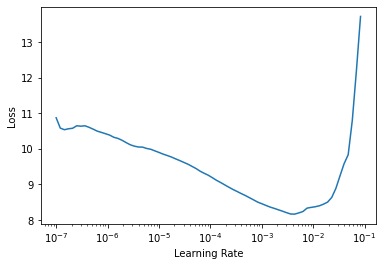

In [ ]:
#모델 구성 후 fine_tuning 진행
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fine_tune(6)

#21분 소요

In [ ]:
#make_line(키워드 혹은 가사 생성시 사용할 미끼가사 , 문장의 길이)
#output = KoGPT2로 생성한 가사

def make_line(rhyme_word,word_len):
  prompt= rhyme_word
  prompt_ids = tokenizer.encode(prompt)
  inp = tensor(prompt_ids)[None].cuda()
  preds = learn.model.generate(inp,
                           max_length=word_len,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
  return tokenizer.decode(preds[0].cpu().numpy())

In [29]:
#어떠한 결과가 나오는지 확인하는 예시

prompt=" 성공 성경 전공 공공"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'성공 성경 전공 공공팀 왔다갔어 난 너를 잃어 멘탈은 안돼 내 맘을 몰라줘서 고마워요 오빠는 너무 성격 좋아 여자가 많을 것 같아 아 많잖아 나 사랑에 빠졌나 봐 어떡해 기가 막혀 와 근데 왜이래 자꾸만 날 흔들어 놔두고 싶어 이젠 됐고 싶어져 어쩌라고 저렇다고 하더니 뭐가 그리 겁이나 내가 더 무서워져 아무리 애원해도 웃게 돼 그래도 나는 어쩔 수 없는데 어떻게 하면 다 티비를 지르는건지 그런 일이야 그럴 리가 없지 오오 뜬 눈으로 밤을 새우며 그'

In [ ]:
#어떠한 결과가 나오는지 확인하는 예시

a1 = make_line("러브",20)
a2 = make_line(a1 + "허브",40)
a3 = make_line(a2 + "레드",60)
a4 = make_line(a3 + "무드",80)
print(a4)

러브액션 너무너무 부럽지 않은 너의 red lips 이런 내허브식으론 부족해 이젠 내게서 달아나 어디든 상관없어 난 다시 태어나레드래 날 비추는 햇빛 아래서 바라봐 네가 떠나간 후 느낄 수 있게 내가 널무드 오 아침을 맞은 아이처럼 대지 위에 뿌린 사랑 같아 날카로운 별보다 더 뜨겁게 달라올라


In [ ]:
#구성하고 학습한 모델을 저장 , 모델 경로에 주의
torch.save(model, f'/gdrive/My Drive/Colab Notebooks/corpus_data/model.pt')

## Fine-Tuning 된 모델 사용

In [30]:
#이미 학습된 모델 및 KoGPT2 tokenizer 불러오기

tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = torch.load('/gdrive/My Drive/Colab Notebooks/corpus_data/model.pt')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [31]:
#make_line(키워드 혹은 가사 생성시 사용할 미끼가사 , 문장의 길이)
#output = KoGPT2로 생성한 가사

def make_line(rhyme_word,word_len):
  prompt= rhyme_word
  prompt_ids = tokenizer.encode(prompt)
  inp = tensor(prompt_ids)[None].cuda()
  preds = model.generate(inp,
                           max_length=word_len,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
  return tokenizer.decode(preds[0].cpu().numpy())

In [32]:
#이미 fine-tuning 된 모델 사용 및 결과 확인

print(make_line("진짜 싫어 너",50))

진짜 싫어 너는 몰라 그냥 날 따라와 Bling black it so listen come on girl I wanna dance the floor DJ you know thats my
